### Diabetes data

data and background based on paper: https://www.math.utk.edu/~fernando/Students/GregClark/pdf/Miller-Reaven-Diabetes.pdf

data file: https://www.math.utk.edu/~fernando/Students/GregClark/data/diab.csv

The data set contains data from 145 subjects (some are normal, some have overt diabetes, other have chemical diabetes). Question: Is it possible to cluster the data into those three groups by using the results of the oral glucose tolerace test (ie. plasma glucose, plasma insulin response and insulin resistance -SSPG-)?

"Overt diabetes is the most advanced stage, characterized by elevated fasting blood glucose concentration and classical symptoms. This stage is divided into ketotic and nonketotic forms. Preceding overt diabetes is the latent or chemical diabetic stage, with no symptoms of diabetes but demonstrable abnormality of oral or intravenous glucose tolerance."
(https://deepblue.lib.umich.edu/handle/2027.42/33955)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
from consensus_clustering.load_data import scale_data
import pandas as pd
import sys
from pandas.plotting import scatter_matrix
import seaborn.apionly as sns
import csv
#sns.set(style="ticks", color_codes=True)
%matplotlib inline

### Load data

In [2]:
data_diab= np.zeros((145,5))

In [3]:
r=0
c=0
with open('.\\consensus_clustering\\data\\diab.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        c=0
        for element in row:
            data_diab[r,c]=float(element)
            c+=1
        r+=1

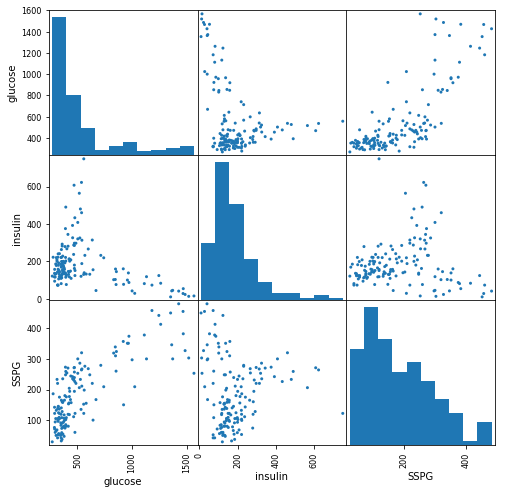

In [4]:
data_subset=data_diab[:,2:5] #select data we are interested in
dataframe_subset=pd.DataFrame(data_subset,columns=["glucose","insulin","SSPG"])

s=scatter_matrix(dataframe_subset[["glucose","insulin","SSPG"]], alpha=1, figsize=(8,8), cmap='Set2')

In [5]:
data=scale_data(data_subset) #scale data for clustering

### Mean Shift Example

58 iterations until termination.
Used bandwidth: 0.460000
Finished after 0.3912423141234954
Number of clusters found: 4.000000
There is/are 1.000000 outliers
Max within cluster distance to center: 0.007509
Mean within cluster distance to center: 0.001165
Sum of within cluster squared errors: 0.000466


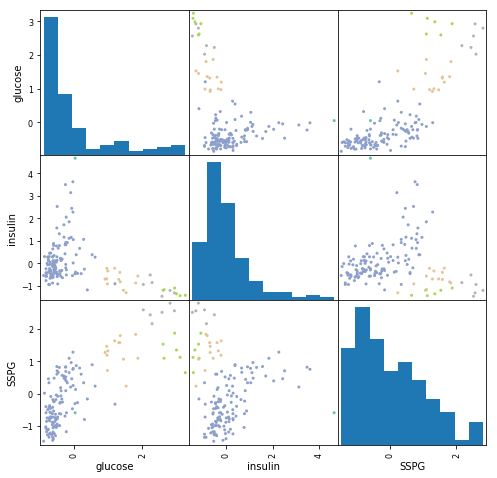

In [6]:
#mean shift algorithm
ms_obj = density.MeanShift(data, bandwidth=0.46, mindist=0.03)
ms_obj.fit()
labels = ms_obj.cluster_labels

#visualization as 4x4 plots for each of the 4 dimensions
dataframems=pd.DataFrame(data,columns=["glucose","insulin","SSPG"])
dataframems["labels"]=labels
s=scatter_matrix(dataframems[["glucose","insulin","SSPG"]], alpha=1, figsize=(8,8), c = labels, cmap='Set2')

### KMeans Example

terminated by break condition
6 iterations until termination.
Finished after 0:00:00.009036
max within-cluster distance to center: 3.231485
mean within-cluster distance to center: 0.797333
sum of within cluster squared errors: 118.399765


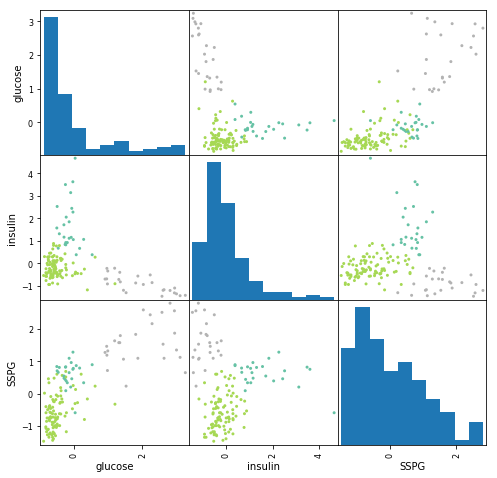

In [7]:
k = 3

# Fit
kmeans_obj = cl_dist.KMeans(data, k)
kmeans_obj.fit()
labels = kmeans_obj.cluster_labels

# Plot
dataframekm=pd.DataFrame(data,columns=["glucose","insulin","SSPG"])
dataframekm["labels"]=labels
s=scatter_matrix(dataframekm[["glucose","insulin","SSPG"]], alpha=1, figsize=(8,8), c = labels, cmap='Set2')

### Parameter Search for Mean Shift

In [8]:
def plot_results(data, cl_objects, nmi_arr, consensus_obj, algorithm, arr_x, arr_y):
    # Put labels in right order in to the labels array
    no_labels = [0] * len(data)
    clusterings_labels = []
    for obj in cl_objects:
        clusterings_labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
    print("Number of clusterings:", len(clusterings_labels))

    # Init plotting arrangement
    num_plots = len(cl_objects) + 2
    num_subplts_per_row = 6
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int) + 1
    num_x_param = len(arr_x)
    num_y_param = len(arr_y)
    if num_y_param > 1:
        num_subplts_per_row = num_x_param
        num_rows = num_y_param + 1
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row - 1 # do not count first row with original data and consensus
        ax.axis('off')
        if i==0:
            ax.set_title('Original data')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=no_labels, cmap='Set2', alpha=0.2)
        elif i==1:
            ax.set_title('Consensus')
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=consensus_obj.cluster_labels, cmap='Set2', alpha=0.2)
        elif any((i < num_subplts_per_row, i-num_subplts_per_row >= len(clusterings_labels))):
            continue
        else:   
            ax.set_aspect('equal')
            ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i-num_subplts_per_row], cmap='Set2', alpha=0.2)
            if algorithm == 'kmeans':
                ax.set_title('k = {:}, \nNMI = {:.3}'.format(arr_x[cur_x], nmi_arr[i-num_subplts_per_row]))
            elif algorithm == 'dbscan':
#                 print(cur_x)
#                 print(cur_y)
                ax.set_title('eps = {:.3}, minPts = {:}\nNMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row]))
            elif algorithm == 'meanshift':
                ax.set_title('bw = {:.3}, mindist = {:}\nNMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row]))
           
            else:
                print("ERROR: Could not recognize algorithm parameter!")
                break

    plt.tight_layout()
    plt.show()
    #fig.savefig("bandwidth estimation.png")

In [9]:
def param_search_meanshift(data, k_consensus, recluster_what, recluster_how, bandwidth_arr,mindist_arr):
    num_objects = len(bandwidth_arr)
    ms_objects = [None] * num_objects
    ms_obj = None

    print("Fit Mean Shift objects")

    #Fit Mean Shift objects
    for i, (bandwidth, mindist) in enumerate(zip(bandwidth_arr, mindist_arr)):
        sys.stdout.write('\rbandwidth: {0}, mindist: {1}'.format(bandwidth, mindist))
        ms_obj = density.MeanShift(data, bandwidth=bandwidth, mindist=mindist, verbose=False)
        ms_obj.fit()
        ms_objects[i] = ms_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*ms_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(ms_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, ms_objects, consensus_obj

In [10]:
# Set parameters:

# General
stride = 1
data = data
k_consensus = 4
recluster_what = 'points'
recluster_how = 'hierarchical'

# Mean Shift Parameter ranges
#first estimate bandwidth using scotts rule
n,d=np.shape(data)
bw_estimate=n**(-1./(d + 4))
print("The estimate bandwidth using scott's rule is", bw_estimate)

bw_arr = np.arange(0.4, 0.55, 0.05)#bandwidth
mindist_arr = np.linspace(0.02, 0.05, 4) #minimum distance
mesh_bw, mesh_mindist = np.meshgrid(bw_arr, mindist_arr)

The estimate bandwidth using scott's rule is 0.49117148123832816


In [11]:
nmi_arr_ms, cl_objects_ms, consensus_obj_ms = param_search_meanshift(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    bandwidth_arr = mesh_bw.flatten(),
    mindist_arr = mesh_mindist.flatten())

Fit Mean Shift objects
bandwidth: 0.55, mindist: 0.05
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:00.014897
Stopping cluster number was reached.
Current number of clusters: 4
Current minimum cluster distance: 0.75
mutual information: 86.14501455864168
entropy a: -89.74747552625531
entropy b: -118.3743278612146
mutual information: 89.7474755262553
entropy a: -89.74747552625531
entropy b: -98.06524169297465
mutual information: 89.7474755262553
entropy a: -89.74747552625531
entropy b: -97.89779471815362
mutual information: 72.43880134900627
entropy a: -89.74747552625531
entropy b: -72.43880134900628
mutual information: 86.14501455864168
entropy a: -89.74747552625531
entropy b: -118.3743278612146
mutual information: 89.7474755262553
entropy a: -89.74747552625531
entropy b: -98.06524169297465
mutual information: 89.7474755262553
entropy a: -89.74747552625531
entropy b: -97.89779471815362
mutual information: 72.43880134900627
entropy a: -89.74747552625531
entropy b:

Number of clusterings: 16


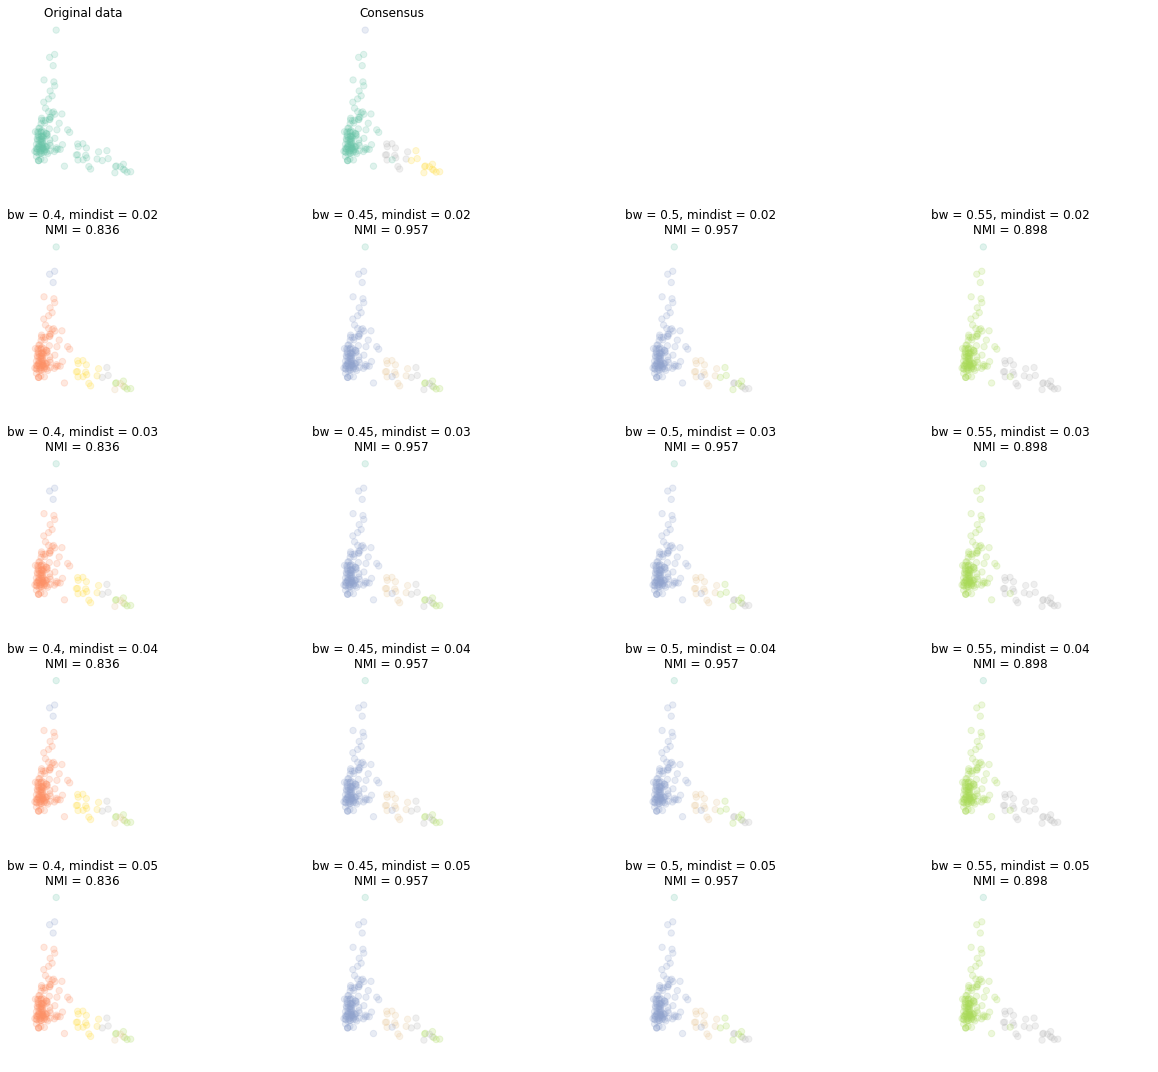

In [12]:
plot_results(data=data, cl_objects=cl_objects_ms, nmi_arr=nmi_arr_ms, consensus_obj=consensus_obj_ms, algorithm='meanshift', arr_x=bw_arr, arr_y=mindist_arr)

Consensus clustering result

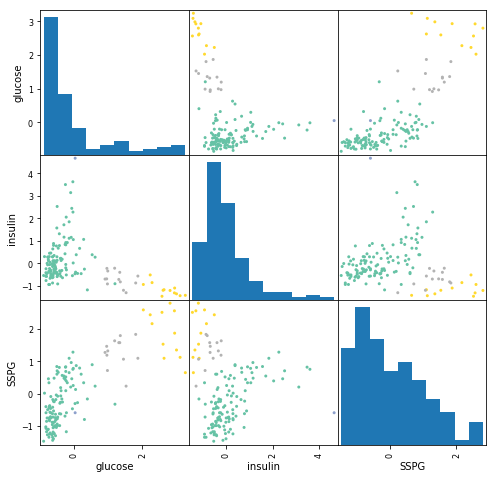

In [13]:
s=scatter_matrix(dataframems[["glucose","insulin","SSPG"]], alpha=1, figsize=(8,8), c = consensus_obj_ms.cluster_labels, cmap='Set2')

In [14]:
#best parameters for DBSCAN -> highest NMI with consensus clustering (might not be unique parameter choice)
print("The best parameter choice for DBSCAN (given the chosen range) has NMI ", np.max(nmi_arr_ms), " compared to the consensus result")

The best parameter choice for DBSCAN (given the chosen range) has NMI  0.957468877718  compared to the consensus result


### Parameter Search for KMeans

In [15]:
def param_search_kmeans(data, k_consensus, recluster_what, recluster_how, k_arr):
    num_objects = len(k_arr)
    kmeans_objects = [None] * num_objects
    kmeans_obj = None

    print("Fit kmeans objects")

    # Fit kmeans objects
    for i, k in enumerate(k_arr):
        kmeans_obj = cl_dist.KMeans(data=data, k=k, verbose=False)
        kmeans_obj.fit()
        kmeans_objects[i] = kmeans_obj

    print("Fit consensus")

    # Fit consensus
    clusterings = [*kmeans_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(kmeans_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, kmeans_objects, consensus_obj

In [16]:
# Set parameters:

# General
data = data
k_consensus = 3
recluster_what = 'points'
recluster_how = 'hierarchical'

#KMeans
km_arr = np.arange(2,6)

In [17]:
nmi_arr_km, cl_objects_km, consensus_obj_km = param_search_kmeans(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    k_arr = km_arr)

Fit kmeans objects
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:00.037880
Stopping cluster number was reached.
Current number of clusters: 3
Current minimum cluster distance: 0.71
mutual information: 66.65548789543274
entropy a: -117.38057843215165
entropy b: -66.65548789543276
mutual information: 102.5567454959648
entropy a: -117.38057843215165
entropy b: -128.06429670552188
mutual information: 99.64684676072665
entropy a: -117.38057843215165
entropy b: -172.5674280402437
mutual information: 117.38057843215165
entropy a: -117.38057843215165
entropy b: -225.44397283938434
Consensus clustering terminated.
Finished after 0:00:00.078158
ANMI (average normalized mutual information) of consensus with clusterings: 0.753
Calculate NMI's
mutual information: 66.65548789543274
entropy a: -117.38057843215165
entropy b: -66.65548789543276
mutual information: 102.5567454959648
entropy a: -117.38057843215165
entropy b: -128.06429670552188
mutual information: 99.6468467607266

Number of clusterings: 4


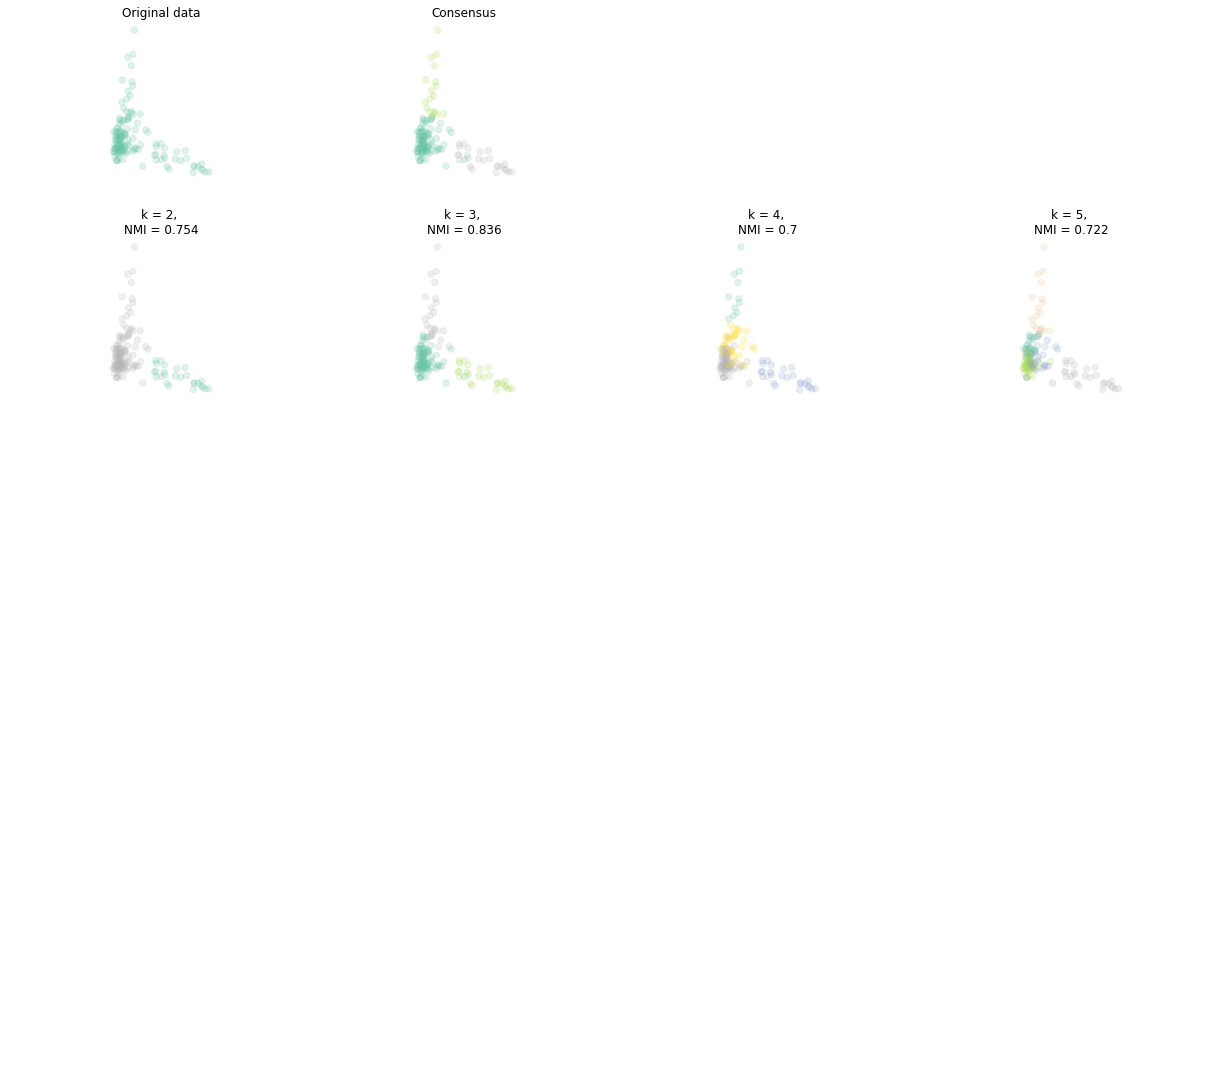

In [18]:
plot_results(data=data, cl_objects=cl_objects_km, nmi_arr=nmi_arr_km, consensus_obj=consensus_obj_km, algorithm='kmeans',  arr_x=km_arr, arr_y=np.zeros(len(km_arr)))

Consensus Clustering result

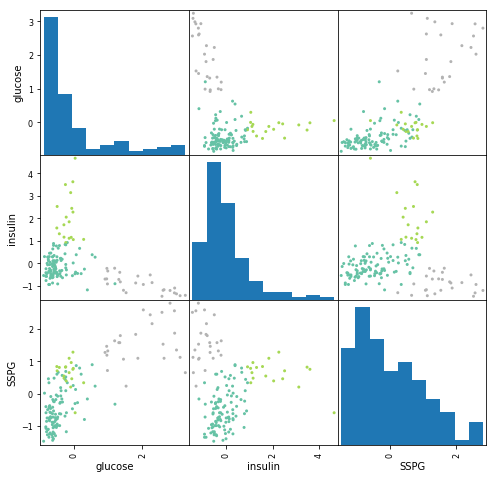

In [19]:
s=scatter_matrix(dataframekm[["glucose","insulin","SSPG"]], alpha=1, figsize=(8,8), c = consensus_obj_km.cluster_labels, cmap='Set2')

In [20]:
#best parameters for DBSCAN -> highest NMI with consensus clustering (might not be unique parameter choice)
print("The best parameter choice for DBSCAN (given the chosen range) has NMI ", np.max(nmi_arr_km), " compared to the consensus result")

The best parameter choice for DBSCAN (given the chosen range) has NMI  0.836473281902  compared to the consensus result


Comparing KMeans and Mean Shift Concensus result

In [21]:
# Calculating the Fowlkes-Mallows index which lies in [0 1], the closer to 1 the better
from sklearn import metrics
mutinf_cons = metrics.adjusted_mutual_info_score(consensus_obj_ms.cluster_labels, consensus_obj_km.cluster_labels)  
fm_index_cons = metrics.fowlkes_mallows_score(consensus_obj_ms.cluster_labels, consensus_obj_km.cluster_labels) 

print("Mutual information between consensus clustering labels of KMeans and Mean Shift:", mutinf_cons)
print("Fowlkes-Mallows index between consensus clustering labels of KMeans and Mean Shift:", fm_index_cons)

Mutual information between consensus clustering labels of KMeans and Mean Shift: 0.572859539344
Fowlkes-Mallows index between consensus clustering labels of KMeans and Mean Shift: 0.857082528411
